<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/MNIST_Val_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/hamish-haggerty/base_rbt.git#egg='base_rbt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hamish-haggerty/base_rbt.git to /tmp/pip-install-vk7hkrn0/base-rbt_eb3fbeb5f35748edb5ae585da16e3c11
  Running command git clone -q https://github.com/hamish-haggerty/base_rbt.git /tmp/pip-install-vk7hkrn0/base-rbt_eb3fbeb5f35748edb5ae585da16e3c11
     |████████████████████████████████| 551 kB 26.0 MB/s 
     |████████████████████████████████| 41 kB 696 kB/s 
     |████████████████████████████████| 548 kB 75.8 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 
  Created wheel for base-rbt: filename=base_rbt-0.0.1-py3-none-any.whl size=20558 sha256=713f9e1844d1789f6d01f2fa97a163a807914787ca7f532856c9f55ae6969d98
  Stored in directory: /tmp/pip-ephem-wheel-cache-uq7u4xnw/wheels/7c/4c/c6/65c6f336ed53f534c05ca6736718e1e18f359920a1ef911674
Successfully built base-rbt


In [2]:
#See commit 11b5b3f for state of system
from base_rbt.base_model import * 
from base_rbt.base_lf import *
from base_rbt.base_linear import *
from base_rbt.helper import *

In [3]:
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rat(pred,I=self.I,lmb=self.lmb)

**Ok now let's do an end to end CIFAR10 example. Let's comment a little more on the API as we go - this will be helpful when considering how to add functionality to (in particular) base_model**

Here are the steps at a high level:
- Define hps (e.g. batch size, projector dimension etc). Note that if the model changes then there may be different hps
- Get the data (train, tune, test) -> dls,dls_val, dls_test
- Patch in loss function definition
- Setup/define augmentations, encoder, model, learner
- Train BT/RBT (i.e. fit the learner
- Train linear classifier and record performance

Step 1): We need the data, and to set all the hps. 

In [5]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
seed=42 #Will have to try with different random seeds. Two times is probably enough 
n_in=1
indim=1024 #find this by inspection, e.g. for resnet18 is 1024
size=28
ps=500 #Will also try with other values e.g. 125, 1000 etc
bs=128 #for training BT
bs_val=20 #for training linear head
bs_test=500
ts_val=bs_val*4 #so 512, ~ 1% of 50000
ts=50000-ts_val #

n_epochs=100 #epochs for BT 
numfit = 200 #epochs for linear classifer


In [6]:
#In this cell we get the data for MNIST (including some helpful functions we can potentially use
#to get CIFAR10 data etc)
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def tune_set(items0,seed=None,bs_tune=20):
    
    seed_everything(seed=seed)
    
    items0=items0.shuffle()
    d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
    ITEMS=[]
    for i in items0:
        s=str(i).split('/training/')[1][0]
        if d[s] is 0 or d[s] is 1:
            ITEMS.append(i)
            d[s]+=1
    #items0=ITEMS

    for i in items0:
        if i not in ITEMS:
            ITEMS.append(i)
            
    split = IndexSplitter(list(range(bs_tune)))
    
    #dls = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
      #                            valid_pct=0.0,num_workers=12,device=device,seed=seed)

    tds_tune = Datasets(ITEMS, [PILImageBW.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
    dls_tune = tds_tune.dataloaders(bs=bs_tune,valid_pct=0.0,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)
    dls_tune.train = dls_tune.valid
    
    return dls_tune


def shuffle_items(items,seed):
    """Helper function to sort a list according to given random seed
    """
    items.sort()
    
    if seed !=None:
        seed_everything(seed=seed)
        items=items.shuffle()
    
    return items

class BT_Data:
    
    def __init__(self,items,seed=42,ts=16384,bs=512,tune_s=2000,bs_tune=20,bs_test=578):
        
        self.ts=ts
        self.bs=bs
        self.tune_s=tune_s
        self.bs_tune=bs_tune
        self.bs_test=bs_test
        
        self._seed=seed
        self.seed=seed
        items=shuffle_items(items,seed)
        self.items=items

    @property
    def seed(self):
        return self._seed
    
    @seed.setter #When we update the seed, we update the datasets (so items and dls objects) accordingly
    def seed(self,val):
        self._seed=val
        self.items = shuffle_items(items,val)
        self.build_items_i()
        self.build_dls()
        
    def build_items_i(self):
        self.items1 = self.items[0:ts] #train BT on these guys
        self.items0 = self.items[self.ts:self.ts+self.tune_s] #for fine tuning - just choose 2000 guys to extract 20 for fine tuning 
        self.items2 = self.items[self.ts+self.tune_s:] #test on remainder
        
    def build_dls(self):
        
        split = RandomSplitter(valid_pct=0.0)
        tds = Datasets(self.items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items1))
        self.dls = tds.dataloaders(bs=self.bs,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

        #Evaluate linear classifier on this guy
        split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
        tds_test = Datasets(self.items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(self.items2)) #Or do we want this?
        self.dls_test = tds_test.dataloaders(bs=self.bs_test,num_workers=6, after_item=[ToTensor(), IntToFloatTensor()], device=device)

path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items.sort()

seed=42
tune_seed=10
ts=16384
bs=512
tune_s=2000
bs_val=20
bs_test=578

bt_data = BT_Data(items=items,seed=seed,ts=ts,bs=bs,tune_s=tune_s,bs_tune=bs_val,bs_test=bs_test)

items1=bt_data.items1
items0=bt_data.items0
items2=bt_data.items2

dls=bt_data.dls
dls_test=bt_data.dls_test
dls_val = tune_set(items0,seed=10,bs_tune=bs_val)

Test the random seed:

Patch in definition of loss function (BT for now):

In [18]:
#| export
class Max_Corr_Mask(nn.Module):
    def __init__(self,qs):
        super().__init__()
        self.qs=qs
        self.mask = torch.ones(qs,qs) * (torch.ones(qs,qs)-torch.eye(qs))
        if default_device().type == 'cuda': self.mask=self.mask.cuda()
        
        self.fc1 = nn.Linear(qs,qs)
        self.fc1.weight.register_hook(lambda grad: grad*self.mask)
        
        self.fc2 = nn.Linear(qs,qs)
        self.fc2.weight.register_hook(lambda grad: grad*self.mask)
        
        self.m1 = nn.Sequential(self.fc1,nn.Sigmoid(),nn.Linear(qs,qs,bias=False))
        self.m2 = nn.Sequential(self.fc2,nn.ReLU(),nn.Linear(qs,qs,bias=False)) #feedforward net one hidden layer
        
    def forward(self,x,y):
        return self.m1(x),self.m2(y)
        
#| export
class Cdiff_Sup:
    
    def __init__(self,I,qs,inner_steps,indep=True,mask=False):
        
        self.I=I
        self.qs=qs
        self.inner_steps=inner_steps
        self.indep=indep
        self.mask=mask
        if self.mask==False: self.max_corr = Max_Corr(qs=qs)
        else: self.max_corr = Max_Corr_Mask(qs=qs)
        if default_device().type == 'cuda':
            self.max_corr.cuda()
        
    def inner_step(self,z1norm,z2norm):
    
        max_corr=self.max_corr
        inner_steps=self.inner_steps
        z1norm=z1norm.detach()
        z2norm=z2norm.detach()
        optimizer = torch.optim.Adam(list(max_corr.parameters()),lr=0.001)
        
        for i in range(inner_steps):
            z1norm_2,z2norm_2=max_corr(z1norm,z2norm)        
            cdiff_2 = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)
            inner_loss=-1*(cdiff_2*(1-self.I)).mean()
            optimizer.zero_grad()
            inner_loss.backward()
            optimizer.step()
        
        for p in max_corr.parameters():
            p.requires_grad=False
            
        return max_corr
    
    def __call__(self,z1norm,z2norm):
        
            max_corr =  self.inner_step(z1norm,z2norm)
            z1norm_2,z2norm_2 = max_corr(z1norm,z2norm)
            cdiff_sup = C_z1z2(z1norm=z1norm,z1norm_2=z1norm_2,z2norm=z2norm,z2norm_2=z2norm_2,indep=self.indep)
    
            return cdiff_sup

In [ ]:
#Using BT
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred, self.I,self.lmb)

In [44]:
def lf_rbt(pred,seed,I,lmb):
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=10,indep=False,mask=True)
    cdiff_2 = CdiffSup(z1norm,z2norm) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=20,indep=True) #Best so far
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    cdiff_2 = 0.5*cdiff_2_2 + 0.5*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

In [79]:
def lf_rbt_enc(pred,seed,I,lmb):

    pred_enc = pred[0]
    pred = pred[1]
    
    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    
    z1_enc, z2_enc = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / z1_enc.std(0, unbiased=False)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / z2_enc.std(0, unbiased=False)
    
    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2

    # #Get either max corr(f(x),g(y)) {if indep=True} or max 0.5*corr(x,g(y)) + 0.5*corr(f(x),y), {if indep=False}
    # #where the max is over f and g. Please see base_lf for details
    CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=15,indep=False,mask=True)
    cdiff_2 = CdiffSup(z1norm_enc,z2norm_enc) #same shape as cdiff

    #As above but f and g are now randomly sampled sinusoid. Please see base_lf for details
    CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=10,indep=True)
    cdiff_2_2 = CdiffRand(z1norm,z2norm) #same shape as cdiff

    #new block
    # CdiffRand = Cdiff_Rand(seed=seed,std=0.1,K=10,indep=True)
    # cdiff_new1 = CdiffRand(z1norm_enc,z2norm_enc) #same shape as cdiff
    # CdiffSup = Cdiff_Sup(I=I,qs=ps,inner_steps=10,indep=False,mask=True)
    # cdiff_new2 = CdiffSup(z1norm_enc,z2norm_enc) #same shape as cdiff
    # cdiff_2 = (0.5*cdiff_new1 + 0.5*cdiff_new2)

    cdiff_2 = 0.8*cdiff_2_2 + 0.2*cdiff_2 #convex combination of rand and sup terms.

    rr = cdiff_2*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #sum of redundancy reduction term and invariance term
    torch.cuda.empty_cache()
    return loss

In [64]:
# #Using RBT_enc
@patch
def lf(self:BarlowTwins, pred,*yb): return lf_rbt_enc(pred,seed=self.seed,I=self.I,lmb=self.lmb)

We also patch `before_epoch` so that we are training linear classifier:
    

Setup for linear evaluation:

In [10]:
aug_pipelines_val=[get_linear_batch_augs(size=28,stats=mnist_stats,resize=True,resize_scale=(0.4, 1.0))]
main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=numfit,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                    dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                    stats=mnist_stats,
                    aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                    encoder=None#encoder
                                )

Optional: Show linear augmentations:

Pipeline: RandomResizedCrop -> Normalize -- {'mean': tensor([[[[0.1310]]]], device='cuda:0'), 'std': tensor([[[[0.3080]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


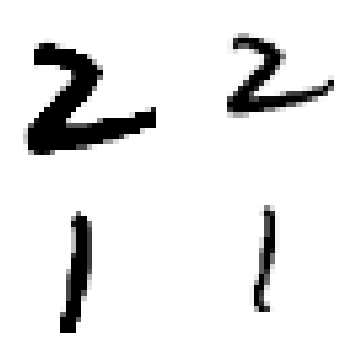

In [ ]:
show_linear_batch(dls=dls_val,n_in=n_in,n=2,aug=aug_pipelines_val,print_augs=True)

Patch linear evaluation into `after_epoch:`

Define encoder and model; Define augmentation pipelines; Define learner.  

In [72]:
fastai_encoder = create_fastai_encoder(xresnet18(),pretrained=False,n_in=n_in)

#If we are using a different model, this call will just look like `create_rat_model(...)`
model = create_p3barlow_twins_model(fastai_encoder, hidden_size=ps,projection_size=ps,nlayers=3)


# aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
#                                                  bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
#                                                  resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
#                                                  bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.2, jitter_p=0.8, blur_p=1.0,sol_p=0.0,
#                                                  stats=mnist_stats,same_on_batch=False, xtra_tfms=[]
#                                                  )

# aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
#                                                  bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
#                                                  resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.025, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
#                                                  bw_p=0.2, flip_p=0.5,rotate_p=0.1,noise_p=0.1, jitter_p=0.8, blur_p=0.1,sol_p=0.2,
#                                                  stats=mnist_stats,same_on_batch=False, xtra_tfms=[]
#                                                  )

aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))

aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=28,blur_r=(0.5,2),
                    rotate=True,jitter=False,noise=True,bw=False,blur=True,solar=True, #Whether to use aug or not
                    resize_scale=(0.5, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.05, rotate_deg=25,blur_s=11,sol_t=0.025,sol_a=0.025, #hps of augs
                    flip_p=0.1, rotate_p=0.5,noise_p=0.5, jitter_p=0.3, bw_p=0.3, blur_p=0.5,sol_p=0.1, #prob of performing aug
                    same_on_batch=False,stats=mnist_stats, cuda=(device=='cuda'))



#aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)

# noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True, #Whether to use  given aug or not
# resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),s1=None,sol_t=0.05,sol_a=0.05, #hps of diff augs
# flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1, #prob of performing aug
# same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[])

aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#If we are using a different `callback` to `BarlowTwins` then we can simply replace `BarlowTwins` with 
#e.g. `BarlowTriplets`. We can define in base_model and just import with no issues. 
learn = Learner(dls,model, cbs=[BarlowTwins(aug_pipelines,n_in=n_in,lmb=1/ps,print_augs=False)])
#Set path of learn correctly
#learn.path = Path('/content/drive/MyDrive/')

Step 3): (Optional): View the augmentations:

In [ ]:
#show_bt_batch(dls=dls,n_in=n_in,aug=aug_pipelines,n=100,print_augs=True)

Step 4): Fit the learner:

In [80]:
#This will also perform linear evaluation every x epochs (see `before_batch`) above 
learn.fit(300) 
#learn.barlow_twins.acc_dict

epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

BT = 0.81-0.82 on 3 epochs

RBT = 0.8453 on 1 tune epoch. convex=0.5,0.5 and K=10=inner_steps. Using mask of course. (Best so far)

RAT

In [77]:
acc_dict

{0: 0.8577229976654053}

In [78]:
#setup
fastai_encoder.eval() #eval mode
fastai_encoder = grad_on(fastai_encoder,on=False) #turn off gradients
#acc_dict={}
for i in range(1,5):
    dls_val = tune_set(items0,seed=seed,bs_tune=seed+i) #use different tune sets

    main_linear_eval = Main_Linear_Eval(size=size,n_in=n_in,numfit=200,indim=1024, #size,n_in=3 (color channels),number of epochs to fit linear, and output dimension of encoder
                            dls_val=dls_val,dls_test=dls_test, #dls for training linear and evaluating linear
                            stats=mnist_stats,
                            aug_pipelines_val=aug_pipelines_val, #aug_pipeline for training 
                            encoder=fastai_encoder #encoder
                                        )
    #main_linear_eval.encoder = self.encoder (usage within BT training)
    acc=main_linear_eval()
    
    acc_dict[i]=acc
    
    print(i)
    print(acc)

print((sum(list(acc_dict.values()))/len(acc_dict.values())))
acc_dict

epoch,train_loss,valid_loss,time
0,2.462284,2.185230,00:01
1,2.319628,1.929689,00:01
2,2.195361,1.696069,00:01
3,2.081959,1.526981,00:01
4,1.957812,1.461203,00:01
5,1.841410,1.141223,00:01
6,1.734590,0.981164,00:01
7,1.631554,1.309949,00:01
8,1.536092,0.685949,00:01
9,1.455727,0.660387,00:01


1
0.8606064915657043


epoch,train_loss,valid_loss,time
0,2.472726,2.195254,00:01
1,2.331275,1.942089,00:01
2,2.207183,1.716461,00:01
3,2.092959,1.542036,00:01
4,1.969816,1.480892,00:01
5,1.853433,1.157326,00:01
6,1.747195,0.998509,00:01
7,1.644151,1.325346,00:01
8,1.548877,0.699826,00:01
9,1.469775,0.673245,00:01


2
0.8630574941635132


epoch,train_loss,valid_loss,time
0,2.474167,2.196805,00:01
1,2.332315,1.943324,00:01
2,2.207664,1.715940,00:01
3,2.093445,1.541448,00:01
4,1.970887,1.487903,00:01
5,1.854506,1.155398,00:01
6,1.748784,0.996348,00:01
7,1.646231,1.326837,00:01
8,1.551052,0.701509,00:01
9,1.473502,0.671432,00:01


3
0.8652921915054321


epoch,train_loss,valid_loss,time
0,2.463691,2.186096,00:01
1,2.322672,1.938594,00:01
2,2.198822,1.713584,00:01
3,2.084244,1.539744,00:01
4,1.962971,1.490222,00:01
5,1.847096,1.159745,00:01
6,1.742682,1.000643,00:01
7,1.641587,1.334488,00:01
8,1.547377,0.705445,00:01
9,1.469839,0.677614,00:01


4
0.8859092593193054
0.8665176868438721


{0: 0.8577229976654053,
 1: 0.8606064915657043,
 2: 0.8630574941635132,
 3: 0.8652921915054321,
 4: 0.8859092593193054}

RBT baseline: 

In [ ]:
#RBT baseline, 300 epochs. Please see lf_rbt_enc and other stuff aboe for implementation. But key points:
#K=10 inner_steps=15 convex=0.8,0.2 and _enc for sup term, _proj for rand term. Sup has just one hidden layer.
#mean=0.8665176868438721
acc_dict={0: 0.8577229976654053,
 1: 0.8606064915657043,
 2: 0.8630574941635132,
 3: 0.8652921915054321,
 4: 0.8859092593193054}

In [ ]:
#BT baseline 300 epochs
#mean = 0.845838
acc_dict = {0: 0.8353037238121033,
 1: 0.8363369703292847,
 2: 0.8404219746589661,
 3: 0.8398692607879639,
 4: 0.8772587180137634}

{0: 0.8353037238121033,
 1: 0.8363369703292847,
 2: 0.8404219746589661,
 3: 0.8398692607879639,
 4: 0.8772587180137634}